In [1]:
import os
import pandas as pd
import numpy as np
import math
import statistics

In [2]:
experiment_data_folders_path = os.path.join(os.getcwd(), "Data", "Experiment")
print(experiment_data_folders_path)

NUMBER_OF_ROUNDS = 10

/home/jovyan/Masterarbeit/Data/Experiment


In [3]:
# for files with a single column of data
def read_lines_from_file_into_df(file_path, column_names):
    # Read all lines from the file
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Strip any whitespace characters from the ends of the lines
    data = [line.strip() for line in lines]
    
    # Create a DataFrame from the data
    df = pd.DataFrame([data], columns=column_names)
    
    return df

# for files with multiple columns of data
def get_df_from_file(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', header=None, names = column_names)
    return df

# for files with a single data point
def read_first_line_from_file(file_path):
    lines = []
    with open(file_path, "r") as f:
        for line in f:
            lines.append(line)

    return lines[0]

def get_movement_timestamps_df_from_interaction_events_df(interaction_events_df):
    grab_events = interaction_events_df[interaction_events_df['EventType'] == 'Grab']
    release_events = interaction_events_df[interaction_events_df['EventType'] == 'Release']
    
    grab_events = grab_events.reset_index(drop=True)
    release_events = release_events.reset_index(drop=True)

    movement_timestamps_df = pd.DataFrame({
        'GrabTimestamp': grab_events['Timestamp'],
        'ReleaseTimestamp': release_events['Timestamp']
    })

    return movement_timestamps_df

# old method
def calculate_distance_and_speed(grab_timestamp, release_timestamp, movement_df):
    # Filter the movement data between the grab and release timestamps
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp) & (movement_df['Timestamp'] <= release_timestamp)]
    
    distances = np.sqrt((movement_data['PositionX'].diff()**2) + 
                        (movement_data['PositionY'].diff()**2) + 
                        (movement_data['PositionZ'].diff()**2))

    distances = distances.dropna()
    
    total_distance = sum(distances)
    #print(f'old calculation total distance: {total_distance}')
    
    time_duration = release_timestamp - grab_timestamp
    
    # Calculate speed (distance / time)
    average_speed = total_distance / time_duration if time_duration > 0 else 0
    
    return total_distance, average_speed

def get_calculated_movement_values(dominant_hand_movement_df, round_data_df, interaction_events_df):

    total_distances = []
    total_path_efficiencies = []
    total_speeds = []

    round_distance_means = []
    round_path_efficiency_means = []
    round_speed_means = []
    
    for i in range(1, NUMBER_OF_ROUNDS + 1):
        round_distances = []
        round_path_efficiencies = []
        round_speeds = []
        
        if i == 1: # first round starts at 0.0
            round_start_timestamp = 0.0
        else: # all other rounds start approx. when the last one finished
            round_start_timestamp = round_data_df.loc[(round_data_df['RoundNumber'] == i - 1), 'RoundEndTimestamp'].values[0]

        #print(f'round: {i}')
        
        round_data = round_data_df[round_data_df['RoundNumber'] == i]
        round_end_timestamp = round_data['RoundEndTimestamp'].values[0]

        blocks = interaction_events_df.loc[(interaction_events_df['Timestamp'] >= round_start_timestamp) & (interaction_events_df['Timestamp'] <= round_end_timestamp), 'Interactable']
        unique_blocks = list(set(blocks))

        for block in unique_blocks:
            #print(f'{block}')
            
            start_timestamp = interaction_events_df.loc[(interaction_events_df['Timestamp'] >= round_start_timestamp) & (interaction_events_df['Timestamp'] <= round_end_timestamp) & (interaction_events_df['Interactable'] == block), 'Timestamp'].values[0]
            end_timestamp = round_end_timestamp

            start_location_data = dominant_hand_movement_df[dominant_hand_movement_df['Timestamp'] == start_timestamp]
            end_location_data = dominant_hand_movement_df[dominant_hand_movement_df['Timestamp'] == end_timestamp]

            start_location_coordinates = [start_location_data['PositionX'].values[0], start_location_data['PositionY'].values[0], start_location_data['PositionZ'].values[0]]
            end_location_coordinates = [end_location_data['PositionX'].values[0], end_location_data['PositionY'].values[0], end_location_data['PositionZ'].values[0]]
            
            shortest_distance = math.dist(start_location_coordinates, end_location_coordinates)
            #print(f'{block} shortest distance: {shortest_distance}')

            grab_events = interaction_events_df[(interaction_events_df['EventType'] == 'Grab') & (interaction_events_df['Interactable'] == block) & (interaction_events_df['Timestamp'] >= round_start_timestamp) & (interaction_events_df['Timestamp'] <= round_end_timestamp)]
            release_events = interaction_events_df[(interaction_events_df['EventType'] == 'Release') & (interaction_events_df['Interactable'] == block) & (interaction_events_df['Timestamp'] >= round_start_timestamp) & (interaction_events_df['Timestamp'] <= round_end_timestamp)]
            
            grab_events = grab_events.reset_index(drop=True)
            release_events = release_events.reset_index(drop=True)
            
            movement_timestamps_df = pd.DataFrame({
                'GrabTimestamp': grab_events['Timestamp'],
                'ReleaseTimestamp': release_events['Timestamp']
            })

            #print(f'movement_timestamps_df: {movement_timestamps_df}')

            single_movement_distances = [] # block can be moved multiple times per round (e.g. dropped or position changed in shelf)
            for index, row in movement_timestamps_df.iterrows():
                #print(f'movement_timestamps row: {row}')
                grab_timestamp = row['GrabTimestamp']
                release_timestamp = row['ReleaseTimestamp']
                single_movement_distance, single_movement_speed = get_distance_and_speed_for_single_movement(grab_timestamp, release_timestamp, dominant_hand_movement_df) # distance of moving block once
                #print(f'single_movement_distance: {single_movement_distance}')

                total_distances.append(single_movement_distance)
                round_distances.append(single_movement_distance)
                single_movement_distances.append(single_movement_distance)
                total_speeds.append(single_movement_speed)
                round_speeds.append(single_movement_speed)
                
            total_distance = sum(single_movement_distances) # total movement distance of block
            #print(f'{block} total distance: {total_distance}')
            #total_distances.append(total_distance)
            
            path_efficiency = total_distance / shortest_distance
            #print(f'{block} path_efficiency: {path_efficiency}')

            total_path_efficiencies.append(path_efficiency)
            round_path_efficiencies.append(path_efficiency)

        round_distance_means.append(statistics.mean(round_distances))
        round_path_efficiency_means.append(statistics.mean(round_path_efficiencies))
        round_speed_means.append(statistics.mean(round_speeds))

    return total_distances, total_path_efficiencies, total_speeds, round_distance_means, round_path_efficiency_means, round_speed_means

def get_distance_and_speed_for_single_movement(grab_timestamp, release_timestamp, movement_df):
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp) & (movement_df['Timestamp'] <= release_timestamp)]

    distance_per_frame = np.sqrt((movement_data['PositionX'].diff()**2) + 
                        (movement_data['PositionY'].diff()**2) + 
                        (movement_data['PositionZ'].diff()**2))

    distance_per_frame = distance_per_frame.dropna()

    distance_per_single_movement = distance_per_frame.sum()
    time_duration = release_timestamp - grab_timestamp
    average_speed = distance_per_single_movement / time_duration if time_duration > 0 else 0
    
    return distance_per_single_movement, average_speed
    
    '''
    foreach round:
        spawned_blocks = getSpawnedBlocksInRound()

        foreach block:
            start_point = location of hand when first grab
            end_point = location of hand when last unsocket OR when round over
            shortest_path = get_distance(start_point, end_point)
    '''

def get_grip_pressure(grab_timestamp, release_timestamp, movement_df):
    # subtract a tolerance (seconds) from grab_timestamp, as grip pressure can rise before item is fully grabbed 
    tolerance = 0.5
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp - tolerance) & (movement_df['Timestamp'] <= release_timestamp)]
    grip_pressure = movement_data['GripPressure'].mean()
    #print(grip_pressure)

    return grip_pressure

def get_round_number(grab_timestamp, round_data):
    for i, row in round_data.iterrows():
        if grab_timestamp <= row['RoundEndTimestamp']:
            return row['RoundNumber']
    return None

def get_correctly_moved_items_percentages(round_data_df):
    percentages = []
    for i in range(len(round_data_df)):  # Get all available rounds
        percentage = round_data_df.iloc[i]['CorrectItems'] / round_data_df['TotalItems']
        percentages.append(percentage)
    return percentages

In [12]:
participants_df = pd.DataFrame()

# Iterate through each folder in the directory
for folder_name in os.listdir(experiment_data_folders_path):
    # Skip if it's not a directory or if it's a hidden/system directory (starts with '.')
    if not os.path.isdir(os.path.join(experiment_data_folders_path, folder_name)) or folder_name.startswith('.'):
        continue

    print('folder name: ' + folder_name)
    folder_path = os.path.join(experiment_data_folders_path, folder_name)

    interaction_events_df = get_df_from_file(os.path.join(folder_path, 'InteractionEvents.txt'), 
                                             ['Timestamp', 'EventType', 'Interactor', 'Interactable'])
    interaction_events_df['Timestamp'] = interaction_events_df['Timestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    interaction_events_df = interaction_events_df.astype({'Timestamp': 'float'})


    movement_timestamps_df = get_movement_timestamps_df_from_interaction_events_df(interaction_events_df)
    
    dominant_hand = read_first_line_from_file(os.path.join(folder_path, 'DominantHand.txt'))

    if not os.path.exists(os.path.join(folder_path, dominant_hand + '.txt')):
        print('No movement data, skipping data participant data set')
        continue
                           
    dominant_hand_movement_df = get_df_from_file(os.path.join(folder_path, dominant_hand + '.txt'), 
                                                ['Timestamp', 'PositionX', 'PositionY', 'PositionZ', 
                                                 'RotationX', 'Rotation Y', 'RotationZ', 'RotationW', 
                                                 'GripPressure'])

    dominant_hand_movement_df = dominant_hand_movement_df.apply(lambda col: col.map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x))
    dominant_hand_movement_df = dominant_hand_movement_df.astype('float')

    #distances = []
    #speeds = []
    grip_pressures = []
    
    # Iterate through each row in movement_timestamps_df
    for index, row in movement_timestamps_df.iterrows():
        grab_timestamp = row['GrabTimestamp']
        release_timestamp = row['ReleaseTimestamp']
        #distance, speed = calculate_distance_and_speed(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        #print(f'distance: {distance}')
        #print(f'speed: {speed}')

        grip_pressure = get_grip_pressure(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        #distances.append(distance)
        #speeds.append(speed)
        grip_pressures.append(grip_pressure)

    movement_timestamps_df['GripPressure'] = grip_pressures
    # Add the results to the DataFrame
    #movement_timestamps_df['Distance'] = distances
    #movement_timestamps_df['Speed'] = speeds
    #print(movement_timestamps_df)
    
    round_data_df = get_df_from_file(os.path.join(folder_path, 'RoundData.txt'), 
                                    ['RoundEndTimestamp', 'RoundNumber', 'RoundType', 'CorrectItems', 'TotalItems'])
    round_data_df['RoundEndTimestamp'] = round_data_df['RoundEndTimestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    round_data_df = round_data_df.astype({'RoundEndTimestamp': 'float'})

    movement_timestamps_df['RoundNumber'] = movement_timestamps_df['GrabTimestamp'].apply(lambda x: get_round_number(x, round_data_df))

    treatment_type = read_first_line_from_file(os.path.join(folder_path, 'TreatmentType.txt'))
    # for some reason, the treatment type file always has a newline character at the end
    treatment_type = treatment_type.replace('\n', '')

    tutorial_time = read_first_line_from_file(os.path.join(folder_path, 'TutorialTime.txt'))
    tutorial_time = float(tutorial_time.replace(',', '.'))  

    # Path efficiency, speed
    total_distances, total_path_efficiencies, total_speeds, round_distance_means, round_path_efficiency_means, round_speed_means = get_calculated_movement_values(dominant_hand_movement_df, round_data_df, interaction_events_df)
    
    mean_total_distance = statistics.mean(total_distances)
    mean_total_path_efficiency = statistics.mean(total_path_efficiencies)
    mean_total_speed = statistics.mean(total_speeds)
    
    participant_df = pd.DataFrame({'FolderName': folder_name,
                                   'TreatmentType': treatment_type,
                                   'TutorialTime': tutorial_time,
                                   'Distance': mean_total_distance,
                                   'PathEfficiency': mean_total_path_efficiency,
                                   'Speed': mean_total_speed,
                                   'TriggerPressure': movement_timestamps_df['GripPressure'].mean(),
                                  }, index=[0])

    for i in range(0, NUMBER_OF_ROUNDS):
        participant_df[f'DistanceRound{i + 1}'] = round_distance_means[i]
        participant_df[f'PathEfficiencyRound{i + 1}'] = round_path_efficiency_means[i]
        participant_df[f'SpeedRound{i + 1}'] = round_speed_means[i]
    
    # Performance
    correct_percentages = get_correctly_moved_items_percentages(round_data_df)
    
    for i in range(len(correct_percentages)):
        participant_df[f'PerformanceRound{i+1}'] = correct_percentages[i]
    
    participant_df['Performance'] = np.mean(correct_percentages)

    round_data_df = round_data_df.astype({'RoundEndTimestamp': 'float'})

    # Group by RoundNumber and calculate mean values
    round_means_df = movement_timestamps_df.groupby('RoundNumber').agg({
        'GripPressure': 'mean'
    }).reset_index()
    #print(round_means_df)
    
    # Add mean GripPressure column for each round
    for _, row in round_means_df.iterrows():
        round_number = int(row['RoundNumber'])
        participant_df[f'TriggerPressureRound{round_number}'] = row['GripPressure']

    
    # df containing raw survey answers
    survey_answers_raw_df = read_lines_from_file_into_df(os.path.join(folder_path, 'SurveyAnswers.txt'), 
                                                     ['GeneralCheck', 
                                                    'CLMentalDemand', 'CLPhysicalDemand', 'CLTemporalDemand', 
                                                    'CLPerformance', 'CLEffort', 'CLFrustration',                                     
                                                    'LeftHandConsciousMovement', 'RightHandConsciousMovement',
                                                    'Presence1', 'Presence2', 'Presence3', 'Presence4', 'Presence5', 'Presence6',
                                                    'ExperienceVR1', 'ExperienceVR2', 'ExperienceVR3',
                                                    'NauseaNausea', 'NauseaDizziness', 
                                                    'VestibularDisorientation', 'VestibularImbalance',
                                                    'OculomotorFatigue', 'OculomotorDiscomfort',
                                                    'Gender', 'Education', 'EmployementStatus', 'Age'
                                                   ])


    # convert all to int except GeneralCheck, Gender, Education and EmploymentStatus
    survey_answers_raw_df = survey_answers_raw_df.astype({'CLMentalDemand': 'int32', 'CLPhysicalDemand': 'int32', 'CLTemporalDemand': 'int32', 
                                                          'CLPerformance': 'int32', 'CLEffort': 'int32', 'CLFrustration': 'int32', 
                                                          'LeftHandConsciousMovement': 'int32', 'RightHandConsciousMovement': 'int32',
                                                          'Presence1': 'int32', 'Presence2': 'int32', 'Presence3': 'int32', 'Presence4': 'int32', 'Presence5': 'int32', 'Presence6': 'int32',
                                                          'ExperienceVR1': 'int32', 'ExperienceVR2': 'int32', 'ExperienceVR3': 'int32',
                                                          'NauseaNausea': 'int32', 'NauseaDizziness': 'int32', 'VestibularDisorientation': 'int32', 'VestibularImbalance': 'int32',
                                                          'OculomotorFatigue': 'int32', 'OculomotorDiscomfort': 'int32',
                                                          'Age': 'int32'
                                                         })
    
    # df containing calculated values of constructs
    survey_answers_df = pd.DataFrame()
    survey_answers_df['GeneralCheck'] = survey_answers_raw_df['GeneralCheck']
    survey_answers_df['CLMentalDemand'] = survey_answers_raw_df['CLMentalDemand']
    survey_answers_df['CLPhysicalDemand'] = survey_answers_raw_df['CLPhysicalDemand']
    survey_answers_df['CLTemporalDemand'] = survey_answers_raw_df['CLTemporalDemand']
    survey_answers_df['CLPerformance'] = survey_answers_raw_df['CLPerformance']
    survey_answers_df['CLEffort'] = survey_answers_raw_df['CLEffort']
    survey_answers_df['CLFrustration'] = survey_answers_raw_df['CLFrustration']
    survey_answers_df['NASA-TLX'] = (survey_answers_raw_df['CLMentalDemand'] + survey_answers_raw_df['CLPhysicalDemand'] + survey_answers_raw_df['CLTemporalDemand'] + survey_answers_raw_df['CLPerformance'] + survey_answers_raw_df['CLFrustration']) / 6
    survey_answers_df['LeftHandConsciousMovement'] = survey_answers_raw_df['LeftHandConsciousMovement']
    survey_answers_df['RightHandConsciousMovement'] = survey_answers_raw_df['RightHandConsciousMovement']
    survey_answers_df['Presence'] = (survey_answers_raw_df['Presence1'] + survey_answers_raw_df['Presence2'] + survey_answers_raw_df['Presence3'] + survey_answers_raw_df['Presence4'] + survey_answers_raw_df['Presence5'] + survey_answers_raw_df['Presence6']) / 6
    survey_answers_df['ExperienceVR1'] = survey_answers_raw_df['ExperienceVR1']
    survey_answers_df['ExperienceVR2'] = survey_answers_raw_df['ExperienceVR2']
    survey_answers_df['ExperienceVR3'] = survey_answers_raw_df['ExperienceVR3']
    survey_answers_df['ExperienceVR'] = (survey_answers_raw_df['ExperienceVR1'] + survey_answers_raw_df['ExperienceVR2'] + survey_answers_raw_df['ExperienceVR3']) / 3
    survey_answers_df['CSQ-VR-NauseaNausea'] = survey_answers_raw_df['NauseaNausea']
    survey_answers_df['CSQ-VR-NauseaDizziness'] = survey_answers_raw_df['NauseaDizziness']
    survey_answers_df['CSQ-VR-Nausea'] = survey_answers_raw_df['NauseaNausea'] + survey_answers_raw_df['NauseaDizziness']
    survey_answers_df['CSQ-VR-VestibularDisorientation'] = survey_answers_raw_df['VestibularDisorientation']
    survey_answers_df['CSQ-VR-VestibularImbalance'] = survey_answers_raw_df['VestibularImbalance']
    survey_answers_df['CSQ-VR-Vestibular'] = survey_answers_raw_df['VestibularDisorientation'] + survey_answers_raw_df['VestibularImbalance']
    survey_answers_df['CSQ-VR-OculomotorFatigue'] = survey_answers_raw_df['OculomotorFatigue']
    survey_answers_df['CSQ-VR-OculomotorDiscomfort'] = survey_answers_raw_df['OculomotorDiscomfort']
    survey_answers_df['CSQ-VR-Oculomotor'] = survey_answers_raw_df['OculomotorFatigue'] + survey_answers_raw_df['OculomotorDiscomfort']
    survey_answers_df['CSQ-VR'] = survey_answers_df['CSQ-VR-Nausea'] + survey_answers_df['CSQ-VR-Vestibular'] + survey_answers_df['CSQ-VR-Oculomotor']
    survey_answers_df['Gender'] = survey_answers_raw_df['Gender']
    survey_answers_df['Education'] = survey_answers_raw_df['Education']
    survey_answers_df['EmployementStatus'] = survey_answers_raw_df['EmployementStatus']
    survey_answers_df['Age'] = survey_answers_raw_df['Age']  
    

    
    participant_df = pd.concat([participant_df.reset_index(drop=True), survey_answers_df.reset_index(drop=True)], axis=1)
        
    participants_df = pd.concat([participants_df, participant_df], ignore_index = True)
    
#print(participants_df.head())
participants_df.to_csv('Experiment.csv', sep = ';', decimal = ',', index=False)

folder name: 75581aef-d32d-46a5-b9f2-095f0cac184b
folder name: d948c4ad-defd-46a9-abd5-5240cfe5899c
folder name: 7399bae9-796c-4a26-9991-5917c26b1223
folder name: b9bb74b1-46a7-497a-9ea1-8ce4a3d00613
folder name: bd05dee3-2ee6-4122-84c8-b597aa6eaa94
folder name: bee3c7bb-9d0c-4938-b244-0d3376c31721
folder name: 2405f21a-bdfb-42bc-95ae-1c6657f2a03d
folder name: d3ad9ccf-ef46-4276-8363-75d652ef2fbb
folder name: 72808563-2c2c-4913-b5ec-2439e8141bbe
folder name: 8ff30652-6b8e-49a2-8cb5-de9af5e64705
folder name: ddea3ca7-bc96-41ab-9cfa-c99e50297a2e
folder name: 827068f3-0085-4437-ab51-d06b25fba03f
folder name: 96b39d34-f56d-4055-b7b0-2768a21ed318
folder name: d29b3590-6b60-4622-bcc7-c30b5325af80
folder name: 980e327b-82e4-4816-a0f3-e4beabf8fd86
folder name: aaae5fe8-3e5f-461b-9bc2-6f6221c410b9
folder name: 3143519e-d3e8-472e-b766-de7841d75145
folder name: b6c6f584-4a94-417c-b3a2-4a682bfce4a4
folder name: a069de81-89d8-489b-9832-d77cec090ce8
folder name: bb5a1c3b-94cd-496b-b146-afcf06fa0601


In [8]:
import scipy.stats as stats

def print_participant_statistics(df):
    print("-" * 50)
    print('TutorialTime')

    # Tutorial time histogram
    plt.hist(df['TutorialTime'], bins=30)
    plt.xlabel('Tutorial Time')
    plt.ylabel('Frequency')
    plt.show()
    
    # Tutorial time boxplot
    df.boxplot(column='TutorialTime')
    plt.ylabel('Tutorial Time')
    plt.title('Boxplot of Tutorial Time')
    plt.show()
    print("-" * 50)

    low_cl_participants_count = np.sum(df['TreatmentType'] == 'LowCognitiveLoad')
    high_cl_participants_count = np.sum(df['TreatmentType'] == 'HighCognitiveLoad')
    print('Low CL: ' + str(low_cl_participants_count) + ', High CL: ' + str(high_cl_participants_count))

    mean_age = df['Age'].mean()
    print('Mean age: ' + str(mean_age))
    
    gender_counts = df['Gender'].value_counts()
    education_counts = df['Education'].value_counts()
    employment_counts = df['EmployementStatus'].value_counts()
    
    # Plotting demographics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gender
    axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[0].set_title('Gender Distribution')
    
    # Education
    axes[1].pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[1].set_title('Education Level Distribution')
    
    # Employment Status
    axes[2].pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[2].set_title('Employment Status Distribution')

    plt.show()
    print("-" * 50)

def print_t_test(df, column_name, highClMeanGreaterOrLess):
    alpha = 0.05
    
    # Levene test
    data_low_cl = df.loc[df['TreatmentType'] == 'LowCognitiveLoad', column_name]
    data_high_cl = df.loc[df['TreatmentType'] == 'HighCognitiveLoad', column_name]
    levene_test = stats.levene(data_low_cl, data_high_cl)
    print(levene_test)
    
    isEqualVariance = False
    if(levene_test.pvalue < alpha):
        isEqualVariance = False
        print('Unequal variance')

    else:
        isEqualVariance = True
        print('Equal variance')

    print('')

    t_test = stats.ttest_ind(data_high_cl, data_low_cl, equal_var = isEqualVariance)
    print(t_test)
    if(t_test.pvalue < alpha):
        print('🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾')

        t_test = stats.ttest_ind(data_high_cl, data_low_cl, equal_var = isEqualVariance, alternative = highClMeanGreaterOrLess)
        print(t_test)
        if(t_test.pvalue < alpha):
            print('High CL mean significantly ' + highClMeanGreaterOrLess.upper() + ' than low CL mean')
        else:
            print('Effect seems to be the other way around')
    
    else:
        print('No significant difference between the groups')

def print_boxplot(df, column_name, y_limits):
     # Ensure 'TreatmentType' is treated as a categorical variable with a specific order
    df['TreatmentType'] = pd.Categorical(df['TreatmentType'], categories=['LowCognitiveLoad', 'HighCognitiveLoad'], ordered=True)
    
    df.boxplot(column=column_name, by='TreatmentType', grid=False)
    plt.ylim(y_limits)
    plt.suptitle('')
    plt.title('') 
    plt.ylabel(column_name)
    plt.xlabel('Group')
    plt.savefig(os.path.join(figures_path, column_name + '.png'))
    plt.show()
    
def print_histogram(df, column_name):
    data_low_cl = df.loc[df['TreatmentType'] == 'LowCognitiveLoad', column_name]
    data_high_cl = df.loc[df['TreatmentType'] == 'HighCognitiveLoad', column_name]
    
    plt.subplot(1, 2, 1)  # (Reihen, Spalten, aktueller Plot)
    plt.hist(data_low_cl, bins=8, alpha=0.5, color='skyblue')
    plt.hist(data_high_cl, bins=8, alpha=0.5, color='salmon')
    plt.show()

def print_descriptive_statistics(df, column_name):
    decimal_places = 3
    
    for group in df['TreatmentType'].unique():
        group_data = df[df['TreatmentType'] == group][column_name]
        median = round(np.median(group_data), decimal_places)
        mean = round(np.mean(group_data), decimal_places)
        sd = round(np.std(group_data), decimal_places)
        q1 = round(np.percentile(group_data, 25), decimal_places)
        q3 = round(np.percentile(group_data, 75), decimal_places)
        iqr = q3 - q1
        print(f"Group: {group}")
        print(f"Median: {median}")
        print(f"Mean: {mean}")
        print(f"SD: {sd}")
        print(f"Q1: {q1}")
        print(f"Q3: {q3}")
        print(f"IQR: {iqr}")
        print("-" * 30)

def print_column_analysis(df, column_name, highClMeanGreaterOrLess, y_limits):
    print(column_name)
    print_histogram(df, column_name)
    print_boxplot(df, column_name, y_limits)
    print("-" * 30)

    print_descriptive_statistics(df, column_name)
    print_t_test(df, column_name, highClMeanGreaterOrLess)
    print("-" * 30)

def print_mean_per_round(df, round_column_base_name, ylabel ,y_limits):
    # Calculate regression lines

    # Convert all relevant columns to numeric, coercing errors to NaN
    rounds = [f'{round_column_base_name}{i}' for i in range(1, 11)]
    
    # Extract CorrectlyMovedPercentage for all rounds
    all_rounds = df[rounds].mean()
    
    # Extract CorrectlyMovedPercentage for LowCognitiveLoad
    low_cognitive_load = df[df['TreatmentType'] == 'LowCognitiveLoad'][rounds].mean()
    
    # Extract CorrectlyMovedPercentage for HighCognitiveLoad
    high_cognitive_load = df[df['TreatmentType'] == 'HighCognitiveLoad'][rounds].mean()
    
    # X values for plotting
    x_values = np.arange(1, 11)
    
    plt.figure(figsize=(12, 8))
    plt.ylim(y_limits)
    plt.plot(x_values, all_rounds, label='All participants', marker='o', color='black')
    plt.plot(x_values, low_cognitive_load, label='Low Cognitive Load', marker='o', color='skyblue')
    plt.plot(x_values, high_cognitive_load, label='High Cognitive Load', marker='o', color='salmon')

    plt.xlabel('Round')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, 11))
    
    plt.show()

--------------------------------------------------
TutorialTime


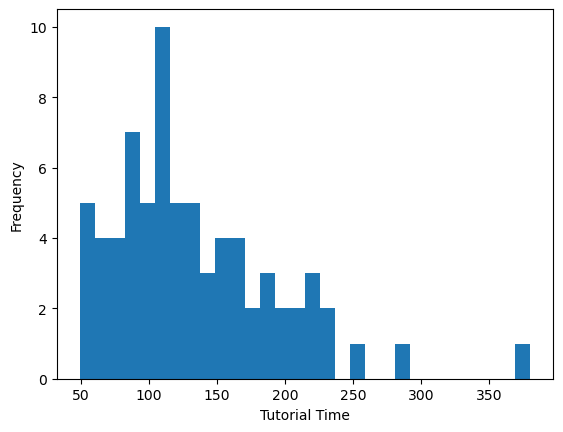

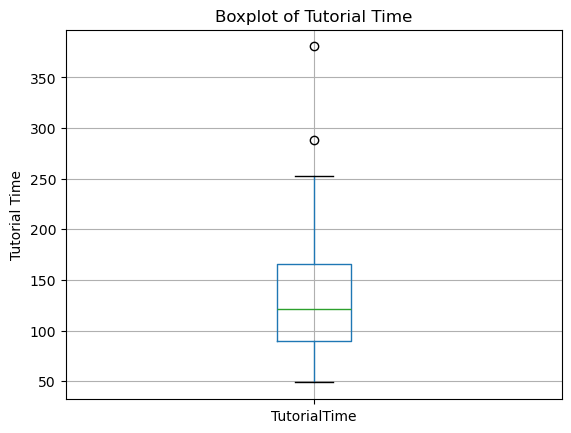

--------------------------------------------------
Low CL: 38, High CL: 35
Mean age: 37.24657534246575


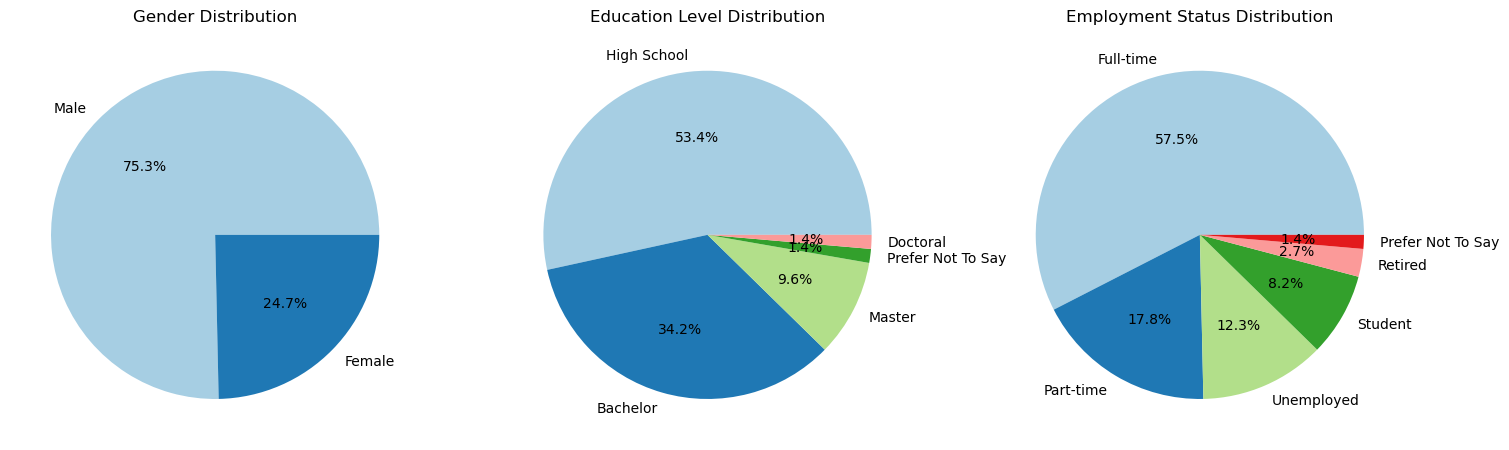

--------------------------------------------------
NASA-TLX


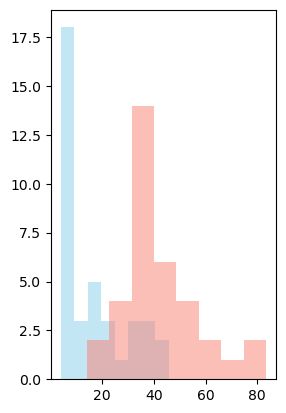

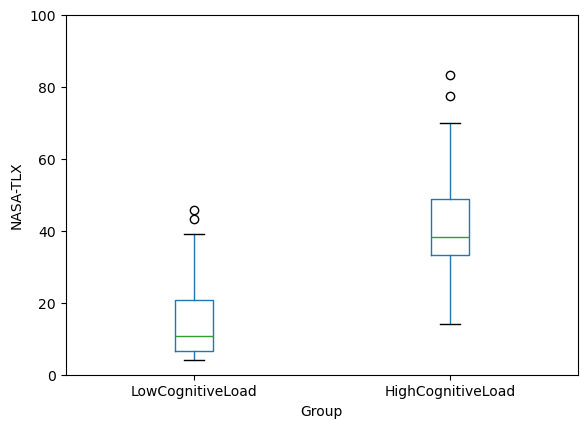

------------------------------
Group: LowCognitiveLoad
Median: 10.833
Mean: 16.557
SD: 12.411
Q1: 6.667
Q3: 20.625
IQR: 13.958
------------------------------
Group: HighCognitiveLoad
Median: 38.333
Mean: 42.333
SD: 14.862
Q1: 33.333
Q3: 48.75
IQR: 15.417000000000002
------------------------------
LeveneResult(statistic=0.2268401836952812, pvalue=0.6353391721661013)
Equal variance

TtestResult(statistic=7.9544814252934675, pvalue=2.0309806601245948e-11, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=7.9544814252934675, pvalue=1.0154903300622974e-11, df=71.0)
High CL mean significantly GREATER than low CL mean
------------------------------


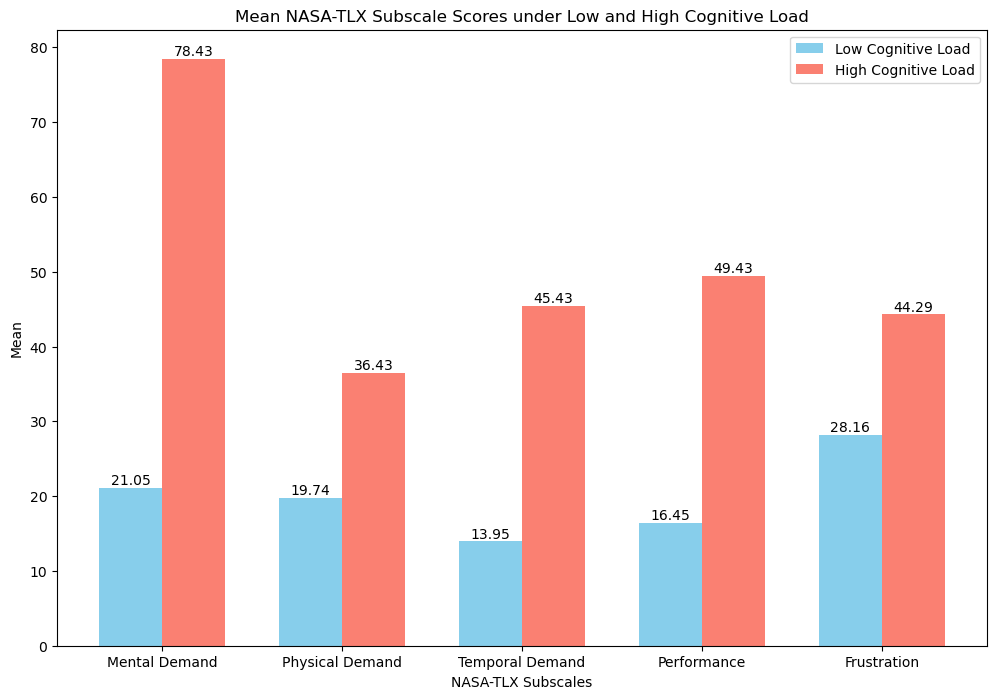

Performance


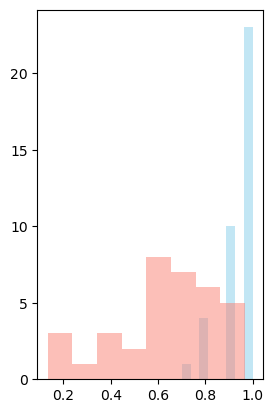

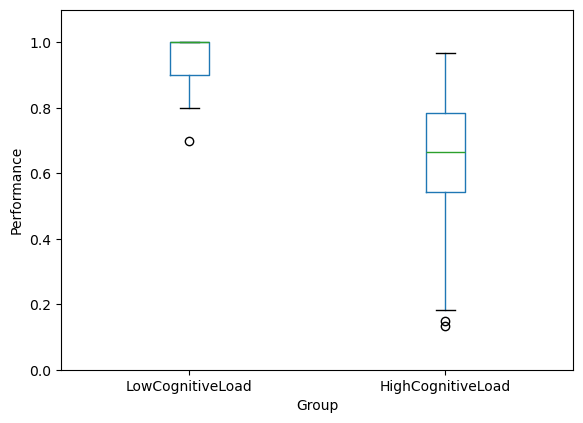

------------------------------
Group: LowCognitiveLoad
Median: 1.0
Mean: 0.945
SD: 0.078
Q1: 0.9
Q3: 1.0
IQR: 0.09999999999999998
------------------------------
Group: HighCognitiveLoad
Median: 0.667
Mean: 0.636
SD: 0.22
Q1: 0.542
Q3: 0.783
IQR: 0.241
------------------------------
LeveneResult(statistic=17.68807211746601, pvalue=7.482051169495731e-05)
Unequal variance

TtestResult(statistic=-7.737744205621592, pvalue=1.328034103290715e-09, df=41.88624041656465)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-7.737744205621592, pvalue=6.640170516453575e-10, df=41.88624041656465)
High CL mean significantly LESS than low CL mean
------------------------------


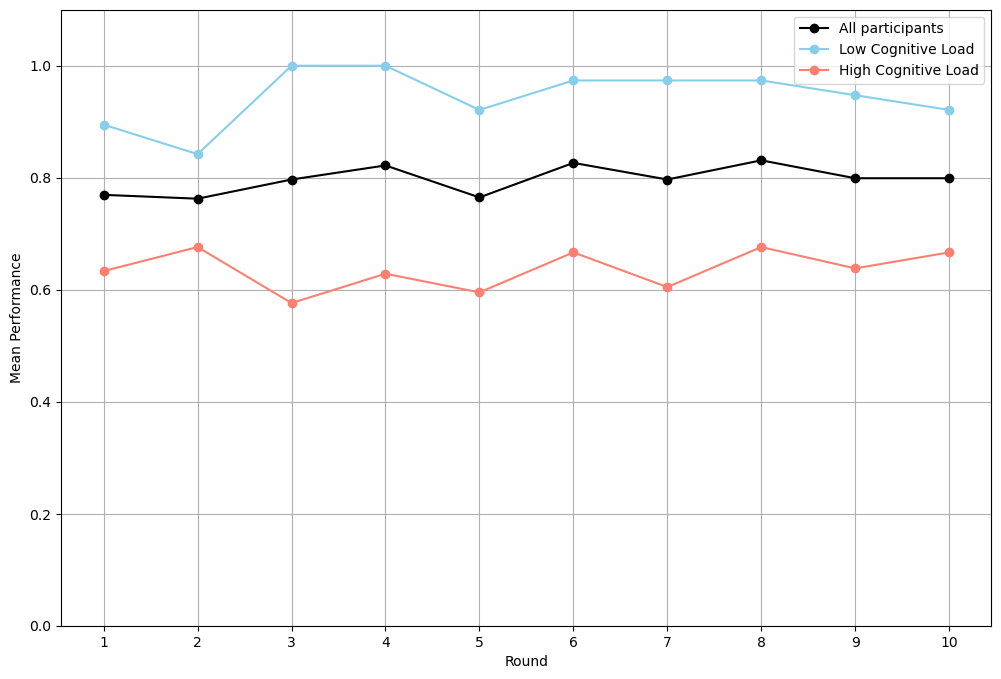

Distance


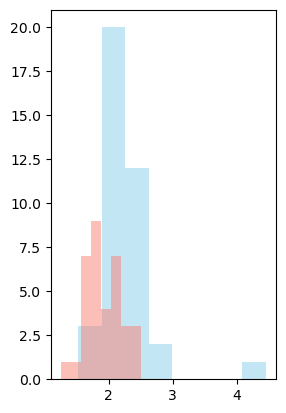

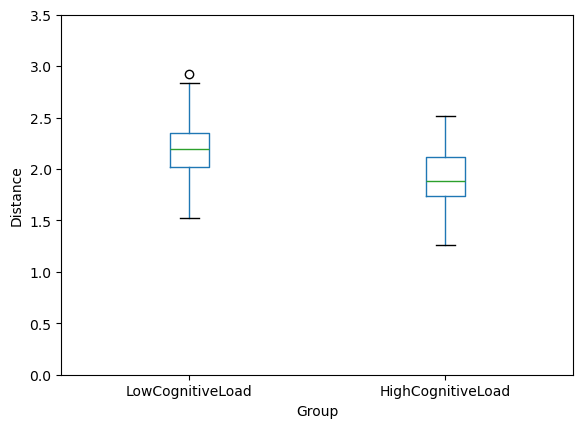

------------------------------
Group: LowCognitiveLoad
Median: 2.196
Mean: 2.246
SD: 0.449
Q1: 2.019
Q3: 2.353
IQR: 0.3340000000000001
------------------------------
Group: HighCognitiveLoad
Median: 1.883
Mean: 1.927
SD: 0.274
Q1: 1.738
Q3: 2.119
IQR: 0.3810000000000002
------------------------------
LeveneResult(statistic=0.23273397822612055, pvalue=0.6309880140388846)
Equal variance

TtestResult(statistic=-3.5837424050214453, pvalue=0.0006171961267614715, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-3.5837424050214453, pvalue=0.00030859806338073576, df=71.0)
High CL mean significantly LESS than low CL mean
------------------------------


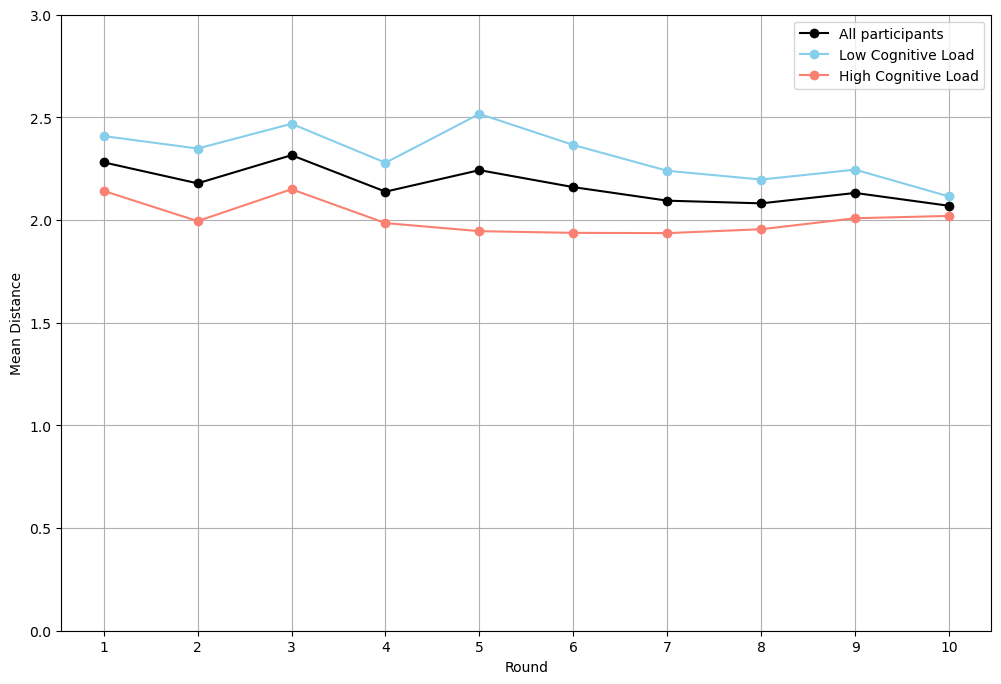

PathEfficiency


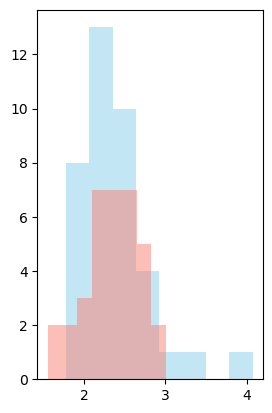

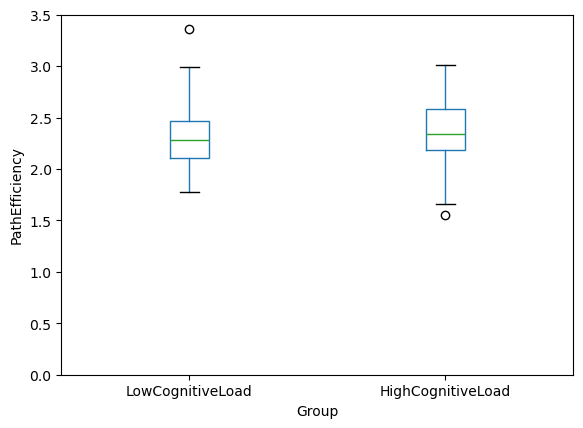

------------------------------
Group: LowCognitiveLoad
Median: 2.285
Mean: 2.371
SD: 0.423
Q1: 2.107
Q3: 2.471
IQR: 0.3639999999999999
------------------------------
Group: HighCognitiveLoad
Median: 2.339
Mean: 2.353
SD: 0.348
Q1: 2.186
Q3: 2.588
IQR: 0.40200000000000014
------------------------------
LeveneResult(statistic=0.036401427952103584, pvalue=0.8492333938614062)
Equal variance

TtestResult(statistic=-0.19302330810860205, pvalue=0.8474918120459751, df=71.0)
No significant difference between the groups
------------------------------


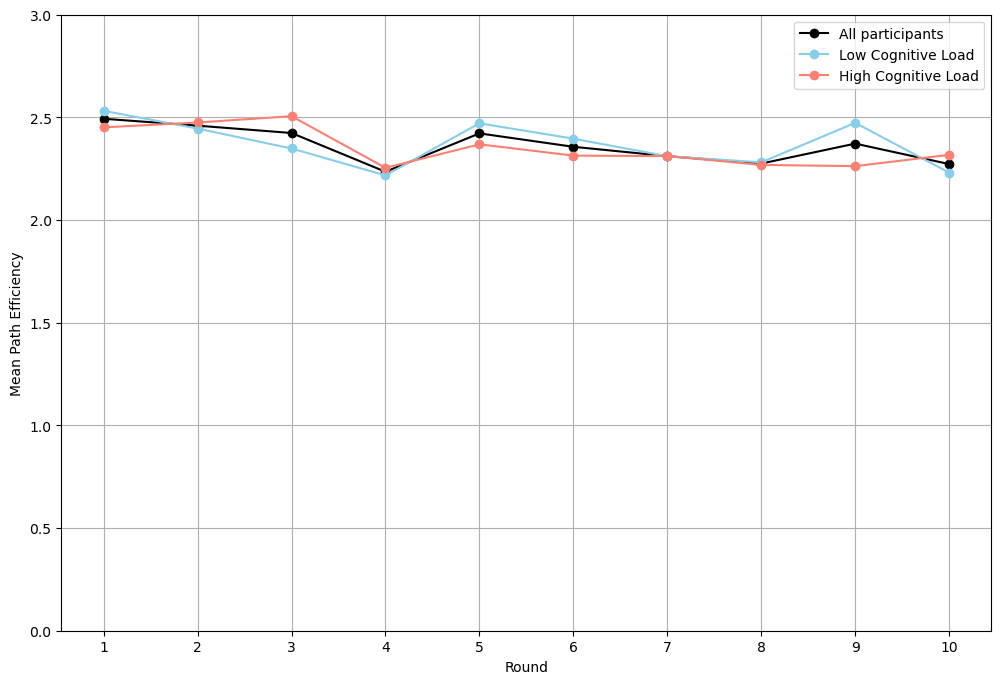

Speed


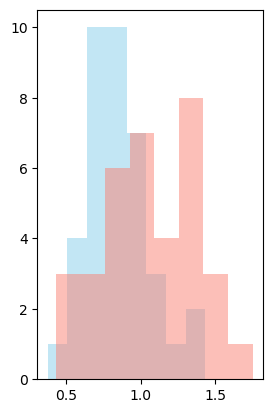

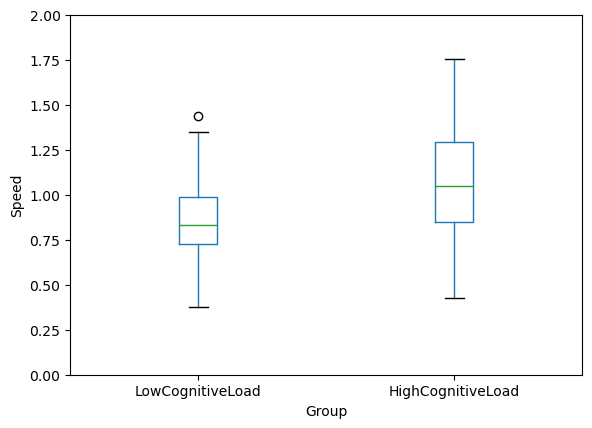

------------------------------
Group: LowCognitiveLoad
Median: 0.832
Mean: 0.857
SD: 0.218
Q1: 0.725
Q3: 0.989
IQR: 0.264
------------------------------
Group: HighCognitiveLoad
Median: 1.048
Mean: 1.067
SD: 0.305
Q1: 0.85
Q3: 1.292
IQR: 0.44200000000000006
------------------------------
LeveneResult(statistic=5.325573520317458, pvalue=0.023932982047757755)
Unequal variance

TtestResult(statistic=3.312335007936955, pvalue=0.001557091922792932, df=61.126660500985594)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=3.312335007936955, pvalue=0.000778545961396466, df=61.126660500985594)
High CL mean significantly GREATER than low CL mean
------------------------------


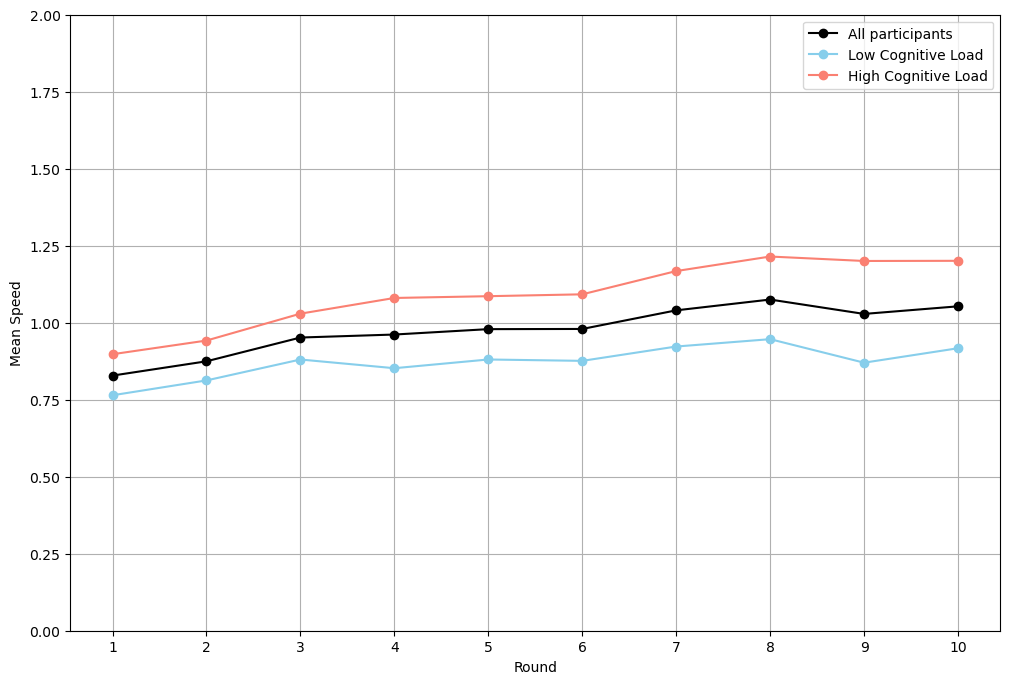

TriggerPressure


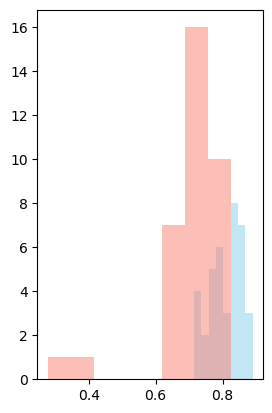

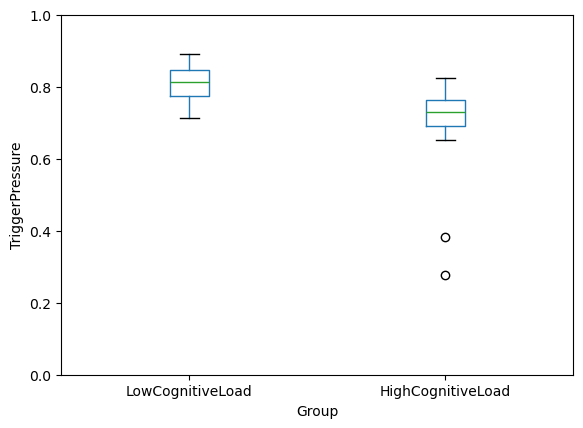

------------------------------
Group: LowCognitiveLoad
Median: 0.814
Mean: 0.807
SD: 0.048
Q1: 0.775
Q3: 0.847
IQR: 0.07199999999999995
------------------------------
Group: HighCognitiveLoad
Median: 0.729
Mean: 0.712
SD: 0.105
Q1: 0.691
Q3: 0.763
IQR: 0.07200000000000006
------------------------------
LeveneResult(statistic=1.5716964736485373, pvalue=0.21407321062631068)
Equal variance

TtestResult(statistic=-4.972605593786768, pvalue=4.42587262195361e-06, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-4.972605593786768, pvalue=2.212936310976805e-06, df=71.0)
High CL mean significantly LESS than low CL mean
------------------------------


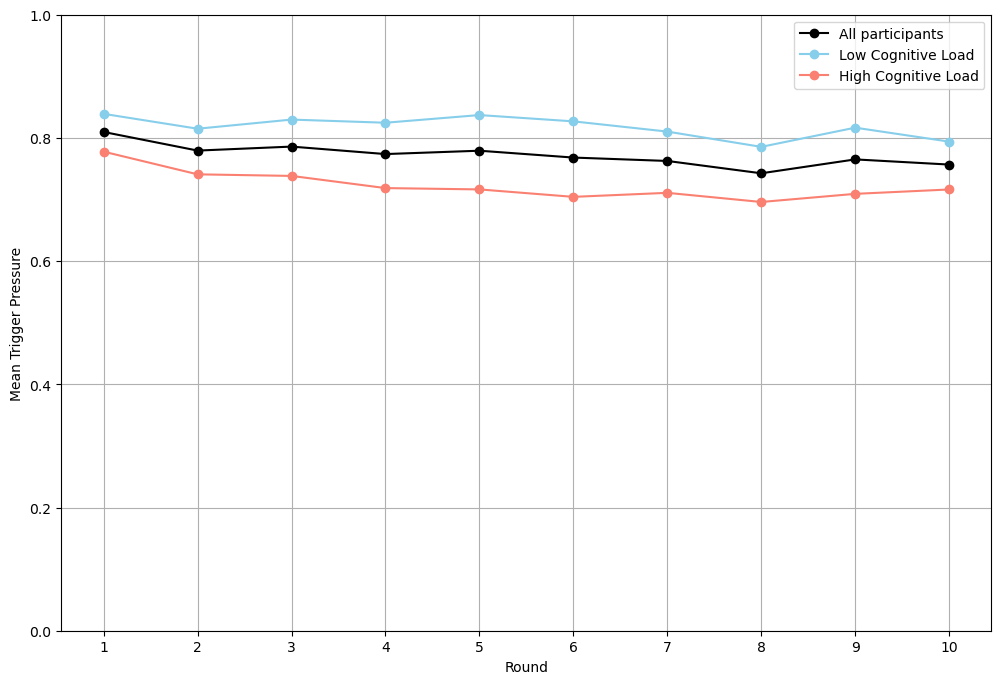

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Statistics, Visualizations and t-Tests

figures_path = os.path.join(os.getcwd(), "Figures")
df = participants_df

print_participant_statistics(df)

print_column_analysis(df, 'NASA-TLX', 'greater', [0, 100])

# Mean values for each subscale
subscales = ['Mental Demand', 'Physical Demand', 'Temporal Demand', 'Performance', 'Frustration']

# Mean values under low and high cognitive load
low_cl_means = [
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLMentalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLPhysicalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLTemporalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLPerformance'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLFrustration'].mean()
]

high_cl_means = [
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLMentalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLPhysicalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLTemporalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLPerformance'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLFrustration'].mean()
]

# X positions for the bars
x = range(len(subscales))

# Width of the bars
width = 0.35

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(x, low_cl_means, width, label='Low Cognitive Load', color='skyblue')
plt.bar([p + width for p in x], high_cl_means, width, label='High Cognitive Load', color='salmon')

# Add labels, title, and legend
plt.xlabel('NASA-TLX Subscales')
plt.ylabel('Mean')
plt.title('Mean NASA-TLX Subscale Scores under Low and High Cognitive Load')
plt.xticks([p + width / 2 for p in x], subscales)
plt.legend()

# Add value labels on top of the bars
for i, v in enumerate(low_cl_means):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(high_cl_means):
    plt.text(i + width, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

#print_column_analysis(df, 'ExperienceVR', 'greater', [0, 7])
#print_column_analysis(df, 'CSQ-VR', 'greater', [0, 42])

print_column_analysis(df, 'Performance', 'less', [0, 1.1])
print_mean_per_round(df, 'PerformanceRound', 'Mean Performance', [0, 1.1])

print_column_analysis(df, 'Distance', 'less', [0, 3.5])
print_mean_per_round(df, 'DistanceRound', 'Mean Distance', [0, 3])

print_column_analysis(df, 'PathEfficiency', 'less', [0, 3.5])
print_mean_per_round(df, 'PathEfficiencyRound', 'Mean Path Efficiency', [0, 3])

print_column_analysis(df, 'Speed', 'greater', [0, 2])
print_mean_per_round(df, 'SpeedRound', 'Mean Speed', [0, 2])

print_column_analysis(df, 'TriggerPressure', 'less', [0,1])
print_mean_per_round(df, 'TriggerPressureRound', 'Mean Trigger Pressure', [0,1])
